## Introductie
In deze EDA ga ik de [hunting mantis](https://www.kaggle.com/datasets/stealthtechnologies/predict-hunting-success-rate-of-a-chinese-mantis) dataset onderzoeken, en een machine learning algoritme op trainen.
Uiteindelijk is het bedoeling om te kunnen voorspellen of een jacht van de mantis succesvol is gebasseerd op een aantal variabelen.
Om dit te kunnen doen zal de data eerst onderzocht moeten worden.





## EDA

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Inlezen

In [294]:
hunting_data = pd.read_csv("./data.csv")
hunting_data.index += 1
hunting_data.head()

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
1,0.32,31.25,Morning,True,0.81,6.600000,False,NaN,True,False,0
2,0.66,29.08,Afternoon,False,2.81,5.380000,False,Low,False,False,1
3,0.61,25.74,Evening,True,3.79,15.189246,True,Low,False,False,1
4,0.37,22.68,Morning,False,4.27,5.060000,True,Low,True,False,1
5,0.65,29.20,Afternoon,False,3.84,2.710000,False,High,False,False,1


In [295]:
hunting_data.shape

(300000, 11)

Alle kolommen en rijen zijn goed ingelezen, shape komt overeen met wat er op de site staat (300000x11).

In [296]:
codebook = {
    "attribute": hunting_data.columns,
    "unit": ["g/m^3", "Celcius", "NA", "True/False", "Minutes", "Cm", "True/False", "NA", "True/False", "True/False", "1/0"],
    "dtype": ["float64", "float64", "category", "bool", "float64", "float64", "bool", "category", "bool", "bool", "int64"],
    "description": [
        "Humidty level of enviroment",
        "Temperature of enviroment",
        "Time of the day",
        "Luring succes",
        "Time spent hunting",
        "Size of prey being hunted",
        "If mantis used an ambush",
        "Amount of food available",
        "If there are predators near",
        "If there is competition",
        "If the hunt was a succes"
    ]
}
pd.DataFrame(codebook)


,attribute,unit,dtype,description
0,Humidity Level,g/m^3,float64,Humidty level of enviroment
1,Temperature,Celcius,float64,Temperature of enviroment
2,Time of Day,NA,category,Time of the day
3,Luring Success,True/False,bool,Luring succes
4,Time Spent Hunting,Minutes,float64,Time spent hunting
5,Prey Size,Cm,float64,Size of prey being hunted
6,Ambush,True/False,bool,If mantis used an ambush
7,Food Availability,NA,category,Amount of food available
8,Predator Presence,True/False,bool,If there are predators near
9,Is Competition,True/False,bool,If there is competition


Deze dataframe bevat informatie over de attributen van de data

### Univariaat

In [297]:
pd.DataFrame({
  "isna": hunting_data.isna().sum()
})

hunting_data = hunting_data.dropna()


Er zijn een aantal missende waarden bij "Food Availability", "Predator Presence", "Is Competition". Ik wil later eerst bepalen hoe relevant deze waarden zijn voordat ik iets aan deze waarden ga doen.

In [298]:
def by_unit(*units):
    return [attribute for attribute, unit in zip(codebook["attribute"], codebook["unit"]) if unit in units]

In [299]:
hunting_data[by_unit("True/False")] = hunting_data[by_unit("True/False")].astype(int)


Om de distributies van numerieke attributen te visualiseren worden boxplotten en histogrammen gebruikt.

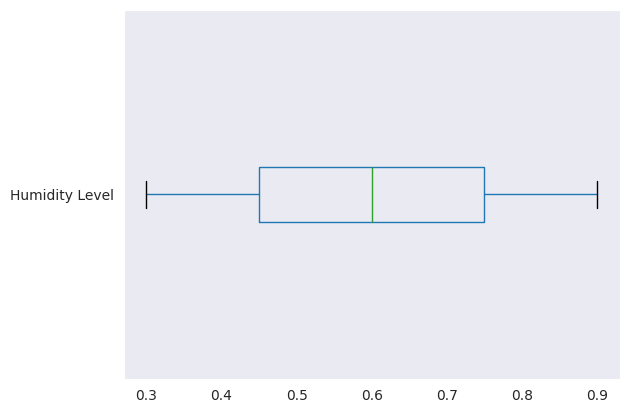

In [300]:
hunting_data[by_unit("g/m^3")].boxplot(vert=False, grid=False);


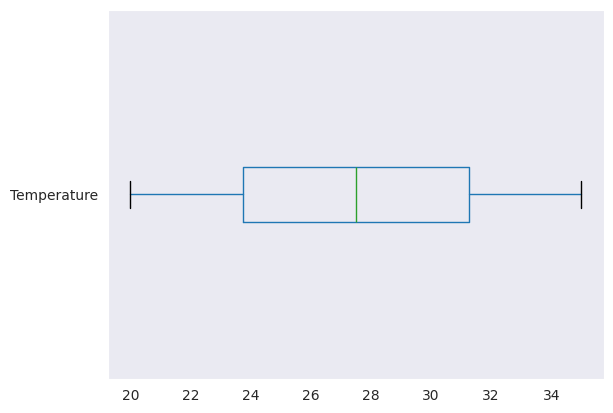

In [301]:
hunting_data[by_unit("Celcius")].boxplot(vert=False, grid=False);

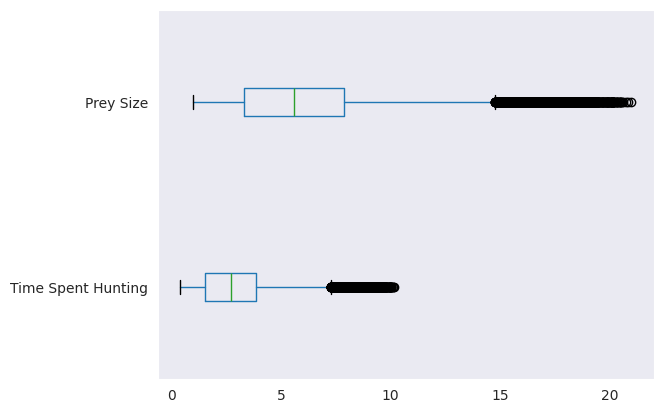

In [302]:
hunting_data[by_unit("Minutes", "Cm")].boxplot(vert=False, grid=False);

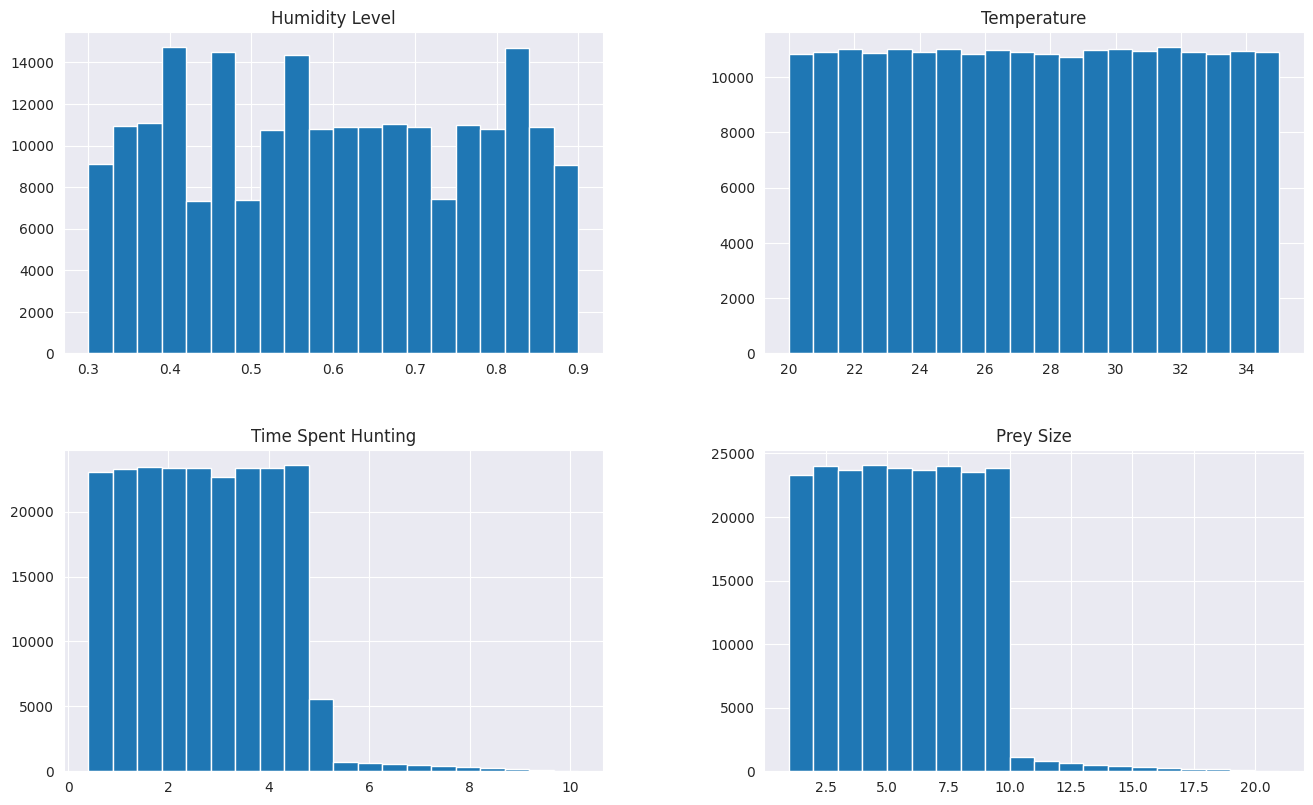

In [303]:
hunting_data[by_unit("g/m^3", "Celcius", "Minutes", "Cm")].hist(bins=20, layout=(2,2), figsize=(16,9.6));

Het is zichtbaar dat de data van temperatuur uniform verdeeld is.
Bij vochtigheid is het niet volledig univorm, sommige nummers komen iets vaker voor dan andere.
De laatste 2 zijn vrij univorm verdeeld, tot een bepaalde waarde (=>5 bij time spent hunting, => 10 bij Prey size). Dit wijst erop dat over het algemeen er minder dan 5 minuten gejaagd wordt. Grotere prooien komen minder vaak voor, wat kan wijzen naar een voorkeur van de mantis.

Ik wil nu de distributies vergelijken van de categorische attributen, "Time of Day" en "Food Availability". Dit wordt gedaan met een barchart

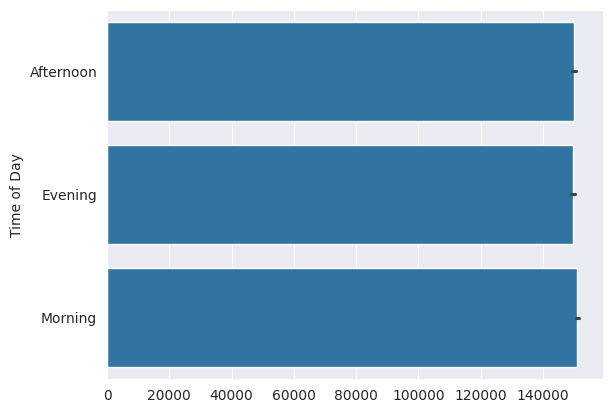

In [304]:
sns.barplot(hunting_data["Time of Day"]);

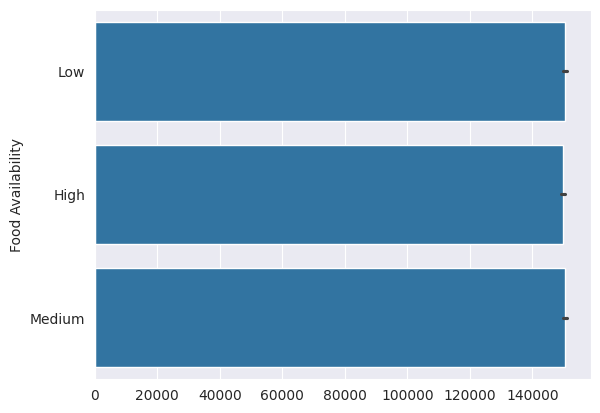

In [305]:
sns.barplot(hunting_data["Food Availability"]);

De 2 categorische features: "Food Availability" en "Time of Day" zijn ook uniform verdeeld


<Axes: >

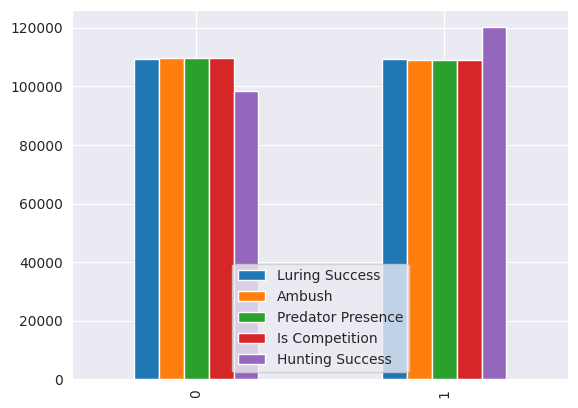

In [306]:
hunting_data[by_unit("True/False", "1/0")].apply(pd.Series.value_counts).plot(kind="bar")

De boolean features zijn ook uniform verdeeld. De verdeling tussen wel en niet is gelijk. Bij hunting success is er zichtbaar dat een geslaagde jacht iets meer voorkomt.

Ik ga nu kijken naar hoe de continue data: humidity,Temperature, prey size, en time spend hunting in verhouding staat met of een jacht succesvol was of niet.

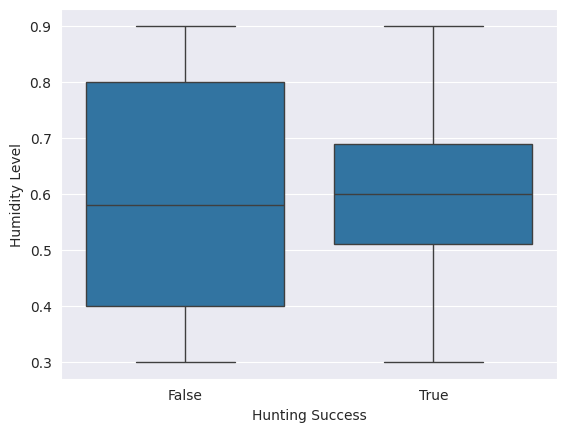

In [307]:
sns.boxplot(y=hunting_data["Humidity Level"], x=hunting_data["Hunting Success"].astype(bool));

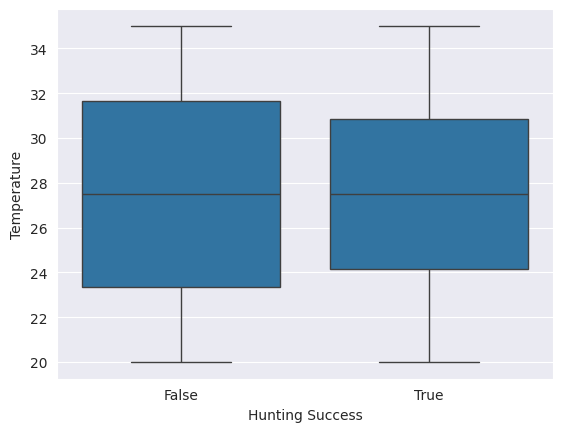

In [308]:
sns.boxplot(y=hunting_data["Temperature"], x=hunting_data["Hunting Success"].astype(bool));

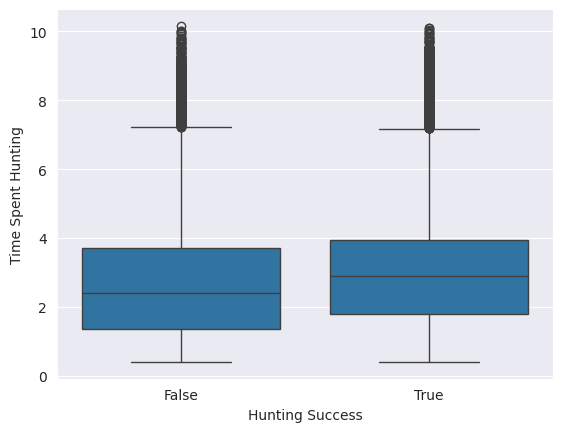

In [309]:
sns.boxplot(y=hunting_data["Time Spent Hunting"], x=hunting_data["Hunting Success"].astype(bool));

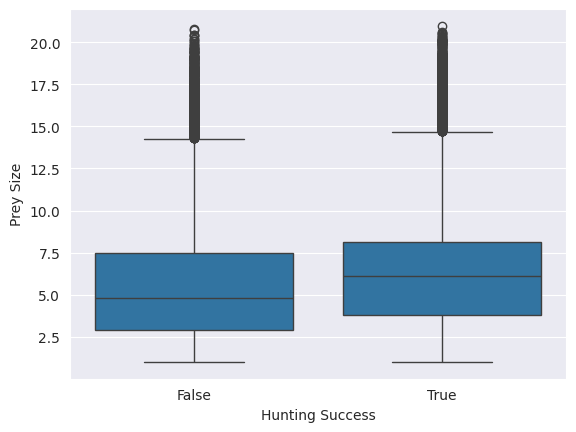

In [310]:
sns.boxplot(y=hunting_data["Prey Size"], x=hunting_data["Hunting Success"].astype(bool));

De IQR van de humidity bij een succesvolle jacht is een stuk kleiner dan bij een niet succesvolle jacht. Dit kan weergeven dat er een optimale vochtigheid is om te gaan jagen.
Bij de andere 3 plotjes komen de boxplotjes wel overeen. Bij Time Spend Hunting en Prey Size ligt de IQR een klein beetje hoger bij een succesvolle jacht, om te bekijken of dit significant is ga ik een two-sample Kolmogorov-Smirnov test uitvoeren. Een t-test zou niet werken, de data is niet normaal verdeeld.


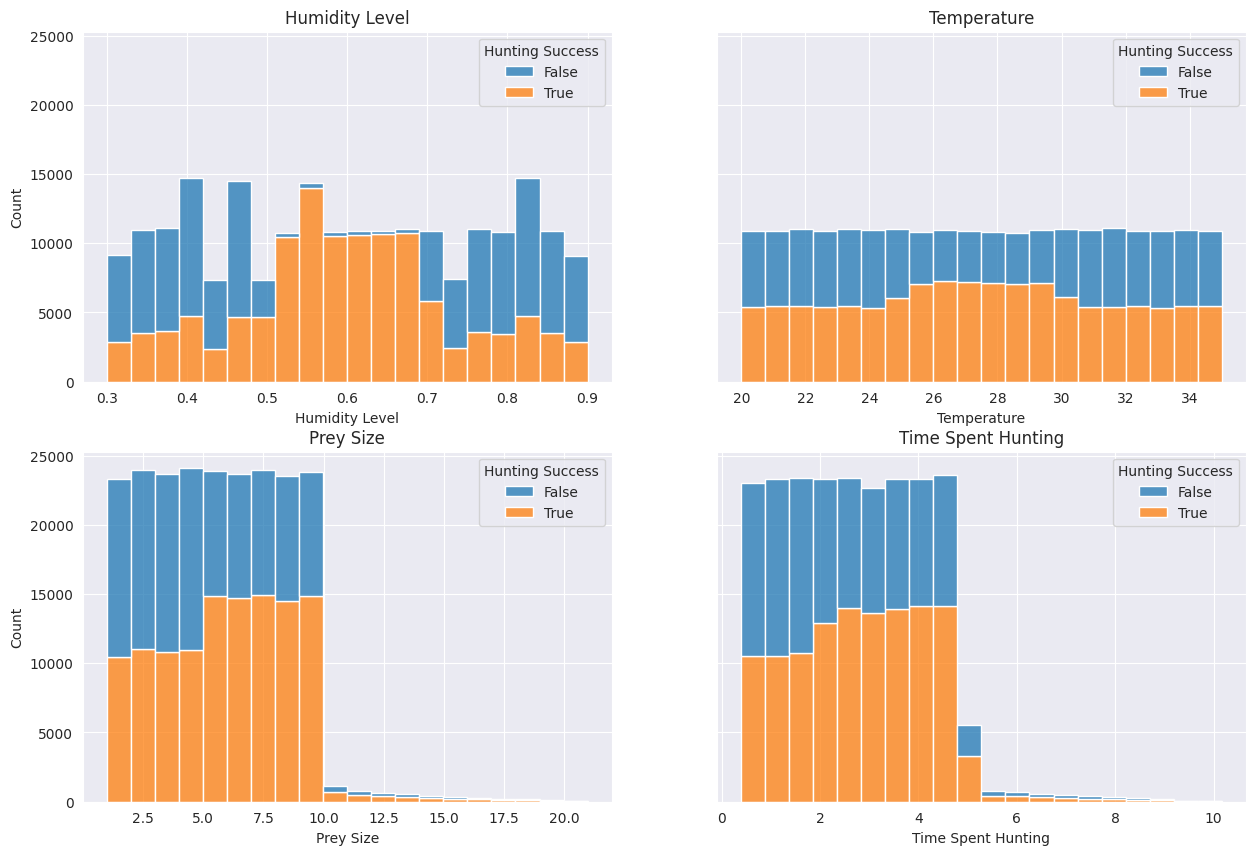

In [315]:
wanted_columns = ["Humidity Level", "Temperature", "Prey Size", "Time Spent Hunting"]

fix, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10));
index = 0
for i in range(0, 2):
    for j in range(0,2):
        sns.histplot(ax = axes[i,j], x=hunting_data[wanted_columns[index]], hue=hunting_data["Hunting Success"].astype(bool), bins=20,multiple='stack');
        axes[i,j].set_title(wanted_columns[index])
        index += 1

Dit geeft weer dat er een optimale vochtigheid en temperatuur blijkt te zijn voor het jagen. Het aantal succesvolle jachten stijgt tussen een vochtigheid van 0.5 en 0.7 G/m^3 en ook bij een temperatuur van 25-28 graden celcius.
Bij time spent hunting en prey size loopt het aantal succesvolle jachten ook een beetje op, maar minder.

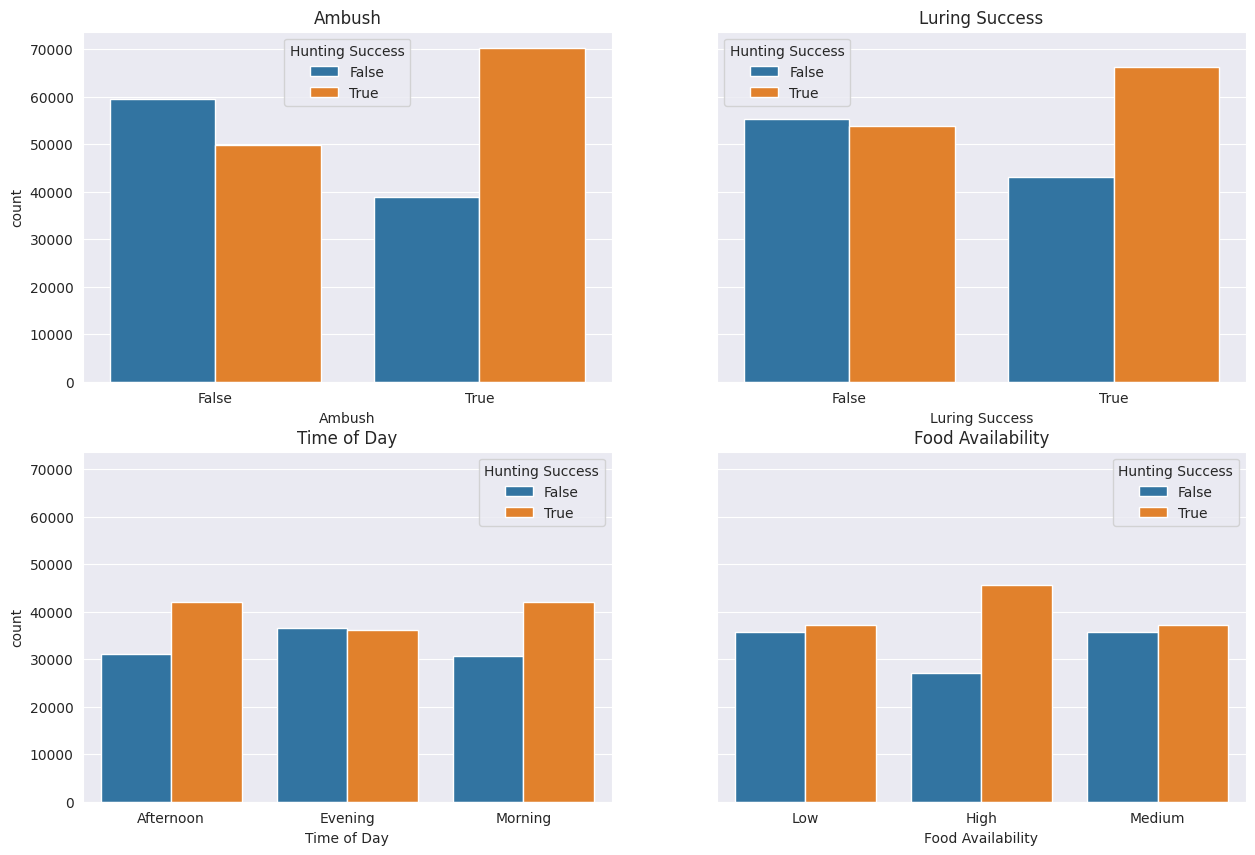

In [335]:
wanted_columns = ["Ambush", "Luring Success", "Time of Day", "Food Availability"]

fix, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10));
index = 0

for i in range(0,2):
    for j in range(0,2):
        ft = codebook["attribute"].to_list().index(wanted_columns[index])
        if codebook["dtype"][ft] == "bool":
            sns.countplot(ax = axes[i,j], x = hunting_data[wanted_columns[index]].astype(bool), hue = hunting_data["Hunting Success"].astype(bool));
        else:
            sns.countplot(ax = axes[i,j], x = hunting_data[wanted_columns[index]], hue = hunting_data["Hunting Success"].astype(bool));
        axes[i,j].set_title(wanted_columns[index])
        index += 1